# Spaceship Titanic Dataset

# Import the library

In [25]:
#!pip install tabpfn 

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Load the Dataset

In [73]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (8693, 14)


The data is composed of 14 columns and 8693 entries. We can see all 14 dimensions of our dataset by printing out the first 5 entries using the following code:

In [74]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [75]:
# Display the first 5 examples
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


There are 12 feature columns. Using these features your model has to predict whether the passenger is rescued or not indicated by the column `Transported`.

In [99]:
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
PassengerId       0
Age               0
Transported       0
GroupSize         0
dtype: int64

Since there are null values, lets complete them mixing 0 and mean. The age will be filled using the mean age and the services will be filled by 0.

<AxesSubplot:>

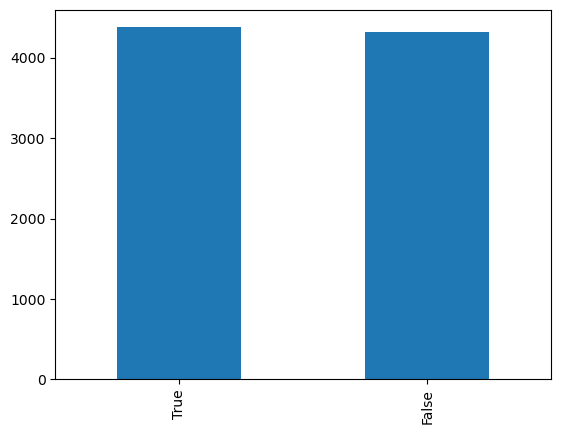

In [76]:
plot_df = dataset_df.Transported.value_counts()
plot_df.plot(kind="bar")

The data seems to be balanced Transported



# Lets do data preprocessing and Feature Engineering

In [86]:
def preprocess_data(df):
    # Convert all Boolean columns
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)
    
    # Encode boolean-like columns
    df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0}).astype('Int64')
    df['VIP'] = df['VIP'].map({True: 1, False: 0}).astype('Int64')
    
    # One-hot encoding for categorical columns
    df = pd.get_dummies(df, columns=['HomePlanet'], prefix='HomePlanet')
    
    # Handle missing values in Cabin
    df['Cabin'] = df['Cabin'].fillna('Unknown/0/Unknown')
    
    # Split Cabin into Deck, Number, and Side
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df = pd.get_dummies(df, columns=['CabinDeck', 'CabinSide'], prefix=['Deck', 'Side'])
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    
    # One-hot encoding for Destination
    df = pd.get_dummies(df, columns=['Destination'], prefix='Dest')
    
    # Split PassengerId into GroupID and PassengerNum
    df[['GroupID', 'PassengerNum']] = df['PassengerId'].str.split('_', expand=True)
    df['GroupID'] = df['GroupID'].astype(int)
    df['PassengerNum'] = df['PassengerNum'].astype(int)
    
    # Compute group size
    group_sizes = df['GroupID'].value_counts()
    df['GroupSize'] = df['GroupID'].map(group_sizes)
    
    # Fill missing values
    df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(value=0)
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    
    # Drop unnecessary columns
    final_df = df.drop(columns=['Name', 'GroupID', 'PassengerNum', 'PassengerId', 'Cabin'])
    
    return final_df

In [87]:
# Define pipeline
xgb_pipeline = Pipeline([
    ('preprocessing', FunctionTransformer(preprocess_data, validate=False))
])


In [88]:
processed_df = xgb_pipeline.transform(dataset_df)

# Numerical data distribution

Let us plot all the numerical columns and their value counts:

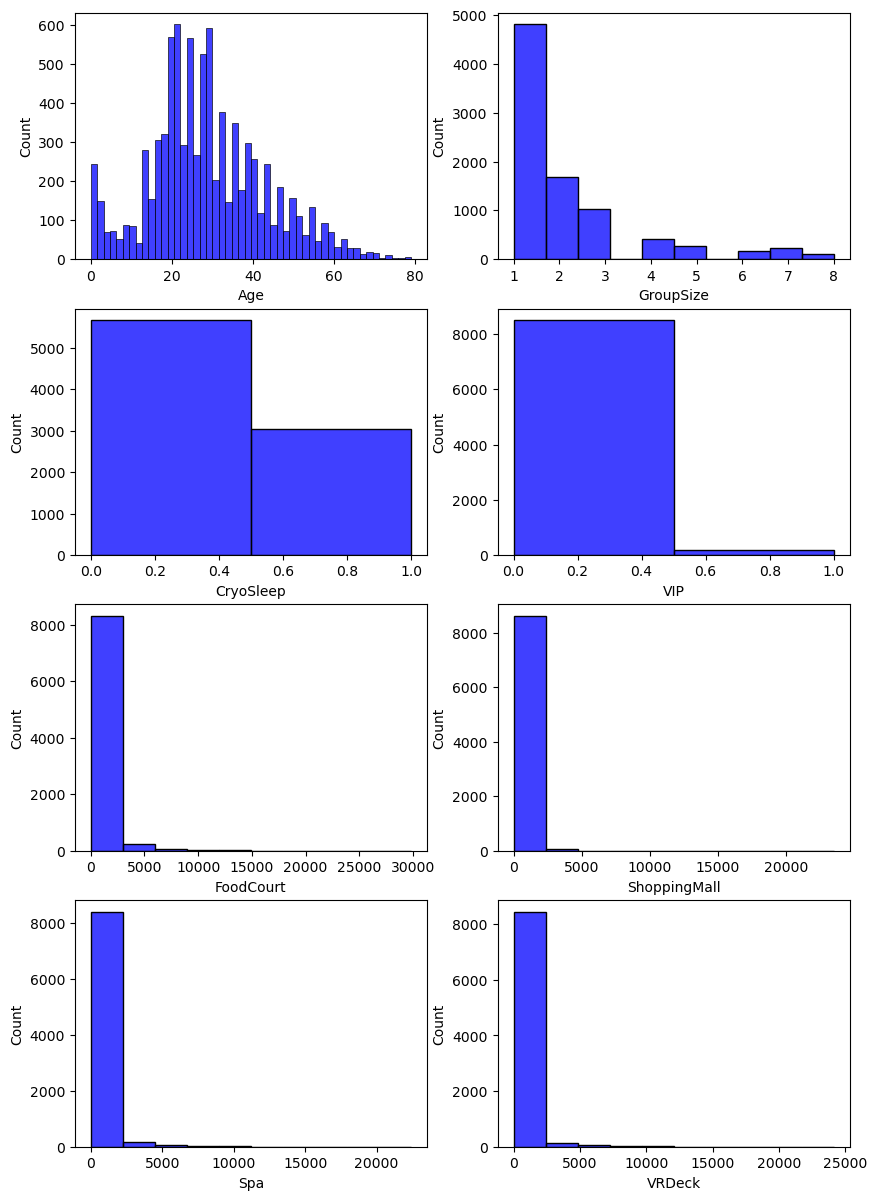

In [95]:
fig, ax = plt.subplots(4,2,  figsize=(10, 6))
plt.subplots_adjust(top = 2)

sns.histplot(titanic_df['Age'], color='b', bins=50, ax=ax[0,0]);
sns.histplot(titanic_df['GroupSize'], color='b', bins=10, ax=ax[0,1]);
sns.histplot(titanic_df['CryoSleep'], color='b', bins=2, ax=ax[1,0]);
sns.histplot(titanic_df['VIP'], color='b', bins=2, ax=ax[1,1]);
sns.histplot(titanic_df['FoodCourt'], color='b', bins=10, ax=ax[2,0]);
sns.histplot(titanic_df['ShoppingMall'], color='b', bins=10, ax=ax[2,1]);
sns.histplot(titanic_df['Spa'], color='b', bins=10, ax=ax[3,0]);
sns.histplot(titanic_df['VRDeck'], color='b', bins=10, ax=ax[3,1]);

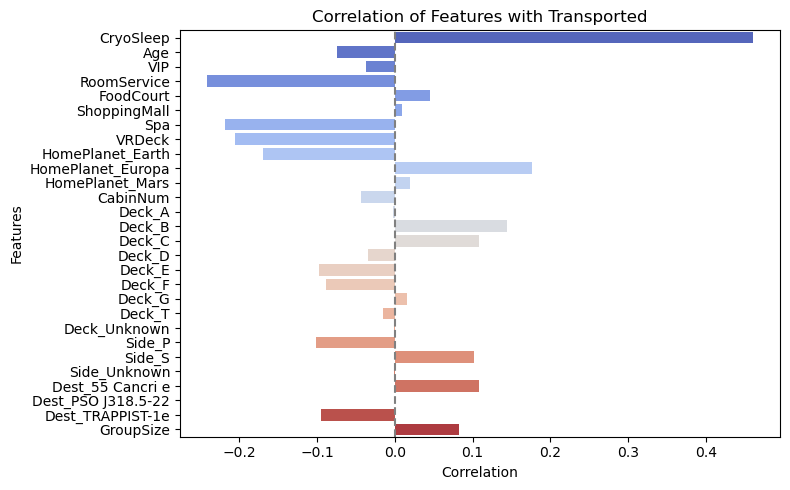

In [96]:
# Select only numeric columns
numeric_df = titanic_df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = titanic_df.corr()

# Extract correlation with 'Transported'
corr_with_target = corr_matrix['Transported'].drop('Transported')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')
plt.title('Correlation of Features with Transported')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

## Train the model¶

In [60]:
# Split the target from the features
X = titanic_df.drop(columns=['Transported'])  # Features
y = titanic_df['Transported']  # Target

Now let us split the dataset into training and testing datasets:

In [61]:
# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [62]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 1.0],  # Fraction of samples used for training each tree
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction
}

In [63]:
# Initialize XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Test Accuracy: 0.8079


# Testing

In [66]:
# Best parameters from GridSearchCV
best_params = grid_search.best_params_

# Train the model using the best parameters
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8079
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       863
           1       0.80      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



# Submission

In [100]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [104]:
processed_test_df = xgb_pipeline.transform(test_df)
submission_id = test_df.PassengerId

In [105]:
# Make predictions on the real test set
y_pred = best_model.predict(processed_test_df)

In [116]:
submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
submission_df['PassengerId'] = submission_id
submission_df['Transported'] = y_pred
submission_df["Transported"] = submission_df["Transported"].astype(bool)
submission_df.to_csv('/kaggle/working/submission.csv', index=False)
submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
